In [152]:
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import LineString, Polygon
import plotly.io as pio
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### 1. Load in data. Create df shape_to_route that maps shape_id to bus route name.

In [99]:
# Load the GTFS files
shapes = pd.read_csv('gtfs_m/shapes.txt')
trips = pd.read_csv('gtfs_m/trips.txt')
routes = pd.read_csv('gtfs_m/routes.txt')

# Merge trips with routes to add route_short_name (bus route number)
trips_routes = trips.merge(routes[['route_id', 'route_short_name']], on='route_id', how='left')

# Drop duplicates to get a unique mapping of shape_id to route number
shape_to_route = trips_routes[['shape_id', 'route_short_name']].drop_duplicates()

### 2. Create data frame of bus stops and filter to CRZ

In [102]:
gdf_stops = gpd.GeoDataFrame(shapes, geometry = gpd.points_from_xy(shapes.shape_pt_lon,shapes.shape_pt_lat))

gdf_stops.head(2)

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence  \
0  M010084     40.720696    -73.997726              10001   
1  M010084     40.720812    -73.997659              10002   

                     geometry  
0   POINT (-73.99773 40.7207)  
1  POINT (-73.99766 40.72081)

In [104]:
# Define CRZ
zone_coords = [(-74.02, 40.70), (-73.93, 40.70), (-73.93, 40.768), (-74.02, 40.768)]
zone_polygon = Polygon(zone_coords)

gdf_zone = gpd.GeoDataFrame({'zone': ['Congestion Pricing']}, geometry=[zone_polygon], crs="EPSG:4326")

# Filter bus stops to only those within the CRZ polygon.
# Make sure gdf_stops is in EPSG:4326
gdf_stops_in_zone = gdf_stops[gdf_stops.geometry.within(zone_polygon)]

def create_line_string(group):
    # Ensure the points are sorted by shape_pt_sequence
    coords = group.sort_values('shape_pt_sequence')[['shape_pt_lon', 'shape_pt_lat']].values
    return LineString(coords)

gdf_routes = gdf_stops_in_zone.groupby('shape_id').apply(create_line_string, include_groups=False).reset_index()
gdf_routes.columns = ['shape_id', 'geometry']
gdf_routes = gpd.GeoDataFrame(gdf_routes, geometry='geometry', crs="EPSG:4326")

gdf_routes.head(2)

shape_id                                           geometry
0  M010084  LINESTRING (-73.99773 40.7207, -73.99766 40.72...
1  M010085  LINESTRING (-73.99037 40.73136, -73.99021 40.7...

### 3. Merge with shape_to_route to get bus route names

In [107]:
gdf_routes = gdf_routes.merge(shape_to_route, on = 'shape_id')

# take first route of each route name
route_dict = {}
for index, row in gdf_routes.iterrows():
    if row['route_short_name'] not in route_dict:
        route_dict[row['route_short_name']] = row['geometry']

dedupe = pd.DataFrame({'route_short_name':route_dict.keys(), 'geometry':route_dict.values()})
dedupe = gpd.GeoDataFrame(dedupe, geometry = 'geometry', crs = 'EPSG:4326')

dedupe.head()

route_short_name                                           geometry
0               M1  LINESTRING (-73.99773 40.7207, -73.99766 40.72...
1               M2  LINESTRING (-73.99037 40.73136, -73.99021 40.7...
2               M3  LINESTRING (-73.99037 40.73136, -73.99021 40.7...
3               M4  LINESTRING (-73.97073 40.76738, -73.97119 40.7...
4               M5  LINESTRING (-73.98903 40.74808, -73.98872 40.7...

### 4. Plot bus routes in CRZ

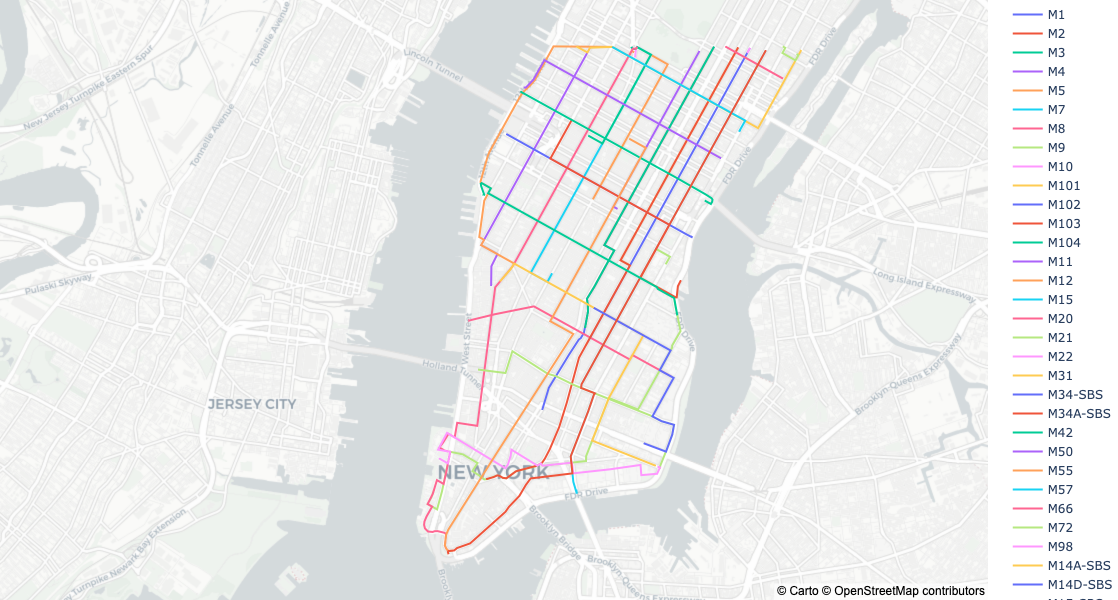

In [110]:
# Ensure your GeoDataFrame is in EPSG:4326
dedupe = dedupe.to_crs(epsg=4326)

# Create a Plotly figure
fig = go.Figure()

# Loop over each route to extract and plot its coordinates
for idx, row in dedupe.iterrows():
    # Check if the geometry is a MultiLineString or a LineString
    if row['geometry'].geom_type == 'MultiLineString':
        for line in row['geometry']:
            x, y = line.xy
            fig.add_trace(go.Scattermapbox(
                mode="lines",
                lon=list(x),
                lat=list(y),
                name=str(row['route_short_name']),
                line=dict(width=2)
            ))
    else:  # LineString
        x, y = row['geometry'].xy
        fig.add_trace(go.Scattermapbox(
            mode="lines",
            lon=list(x),
            lat=list(y),
            name=str(row['route_short_name']),
            line=dict(width=2)
        ))

# Configure the layout of the map
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=12,
    mapbox_center={"lat": 40.735, "lon": -74.0060},  # Centered on NYC
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    height = 600, width = 800
)

fig.show()

In [138]:
# mta bus speeds data
bus_speeds = pd.read_csv('https://data.ny.gov/resource/6ksi-7cxr.csv?$limit=10000&borough=Manhattan')
bus_speeds_2025 = pd.read_csv('https://data.ny.gov/resource/4u4b-jge6.csv?$limit=10000&borough=Manhattan')

bus_speeds = pd.concat([bus_speeds, bus_speeds_2025])
bus_speeds['month'] = pd.to_datetime(bus_speeds.month)

bus_speeds['year'] = bus_speeds.month.apply(lambda x:x.year)
bus_speeds['month_code'] = bus_speeds.month.apply(lambda x:x.month)

bus_speeds.head(2)

month    borough  day_type trip_type route_id    period  total_mileage  \
0 2020-01-01  Manhattan         1   LCL/LTD       M1  Off-Peak     56512652.4   
1 2020-01-01  Manhattan         1   LCL/LTD       M1      Peak     32086461.6   

   total_operating_time  average_speed  year  month_code  
0               9445010           5.98  2020           1  
1               5396283           5.95  2020           1

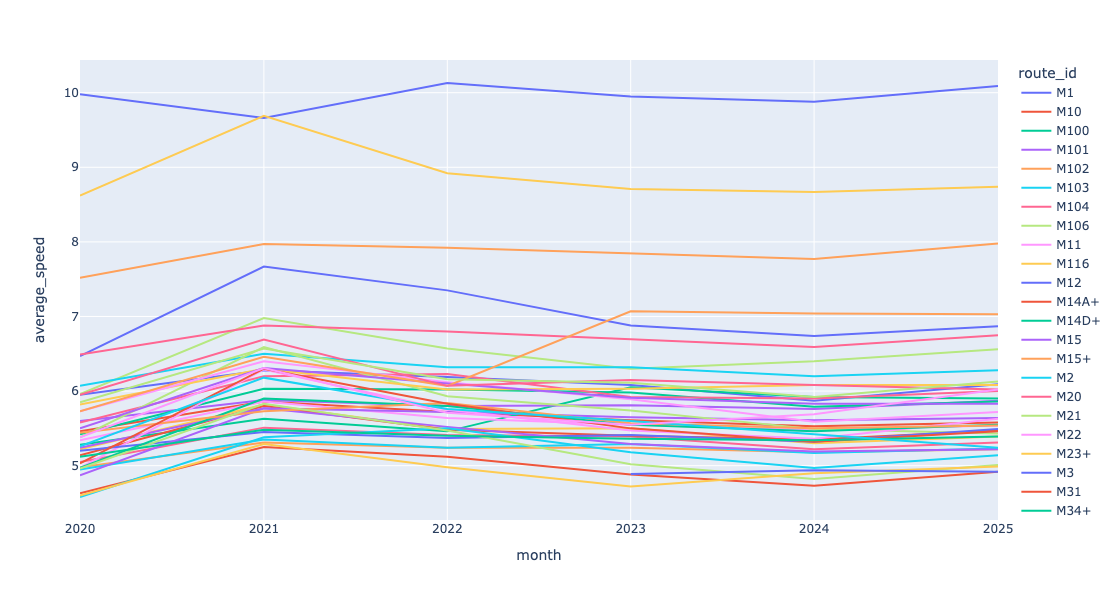

In [148]:
plot = bus_speeds.loc[(bus_speeds.period == 'Peak') &
                      (bus_speeds.day_type == 1) &
                      (bus_speeds.month_code == 1)]

fig = px.line(plot, x = 'month', y = 'average_speed', color = 'route_id')
fig.update_layout(height = 600, width = 800)

fig.show()

In [230]:
improve = {}
for route in plot.route_id.unique():
    slice_df = plot.loc[plot.route_id == route]
    speeds = dict(zip(slice_df.year, slice_df.average_speed))
    if speeds[2025] > speeds[2024]:
        improve[route] = 'Improved'
    else:
        improve[route] = 'No Improvement'

plot['performance'] = plot['route_id'].map(improve)

plot.head(2)

month    borough  day_type trip_type route_id period  total_mileage  \
1 2020-01-01  Manhattan         1   LCL/LTD       M1   Peak     32086461.6   
5 2020-01-01  Manhattan         1   LCL/LTD      M10   Peak     16009628.4   

   total_operating_time  average_speed  year  month_code performance  
1               5396283           5.95  2020           1    Improved  
5               2929943           5.46  2020           1    Improved

In [232]:
fig = go.Figure()

fig.add_trace(go.)

In [166]:
bus_lanes = pd.read_csv('https://data.cityofnewyork.us/api/views/ycrg-ses3/rows.csv?')
bus_lanes['geometry'] = gpd.GeoSeries.from_wkt(bus_lanes['the_geom'])
bus_lanes = gpd.GeoDataFrame(bus_lanes, geometry = 'geometry', crs = 'EPSG:4326')

bus_lanes.head(2)

the_geom         Street TrafDir  \
0  MULTILINESTRING ((-73.96796054798135 40.683726...  FULTON STREET       T   
1  MULTILINESTRING ((-73.96366357791018 40.682806...  FULTON STREET       T   

   SegmentID  RW_TYPE  StreetWidt Boro        Facility     Hours  \
0      29245      1.0           0   BK  Fulton St (WB)  7AM-10AM   
1      29358      1.0           0   BK  Fulton St (EB)   2PM-7PM   

            Days Lane_width  Year1  Year2  Year3 Lane_Type1 Lane_Type2  \
0  Monday-Friday     Single   2018      0      0        NaN        NaN   
1  Monday-Friday     Single   2018      0      0        NaN        NaN   

  SBS_Route1 SBS_Route2  SBS_Route3  Days_Code Last_Updat Lane_Color  \
0        NaN        NaN         NaN          5  2/25/2019        NaN   
1        NaN        NaN         NaN          5  2/25/2019        NaN   

  Open_dates Chron_ID_1  Shape_Leng  \
0  2/25/2019     BK2018  310.046437   
1  2/25/2019     BK2018  293.069021   

                                          Shape_Le_1  \
0  MULTILINESTRING ((993136.0940925032 188378.163...   
1  MULTILINESTRING ((994327.9913150072 188043.381...   

                                            geometry  
0  MULTILINESTRING ((-73.96796 40.68373, -73.9668...  
1  MULTILINESTRING ((-73.96366 40.68281, -73.9626...

In [178]:
# filter to CRZ
bus_lanes = bus_lanes[bus_lanes.geometry.within(zone_polygon)].reset_index(drop=True)

In [206]:
import geopandas as gpd
from shapely.ops import unary_union, linemerge

# Suppose gdf_bus_lanes is your GeoDataFrame
# 1) Combine everything into one geometry
combined = unary_union(bus_lanes.geometry)

# 2) Merge collinear segments that share endpoints
merged = linemerge(combined)

MultiLineString


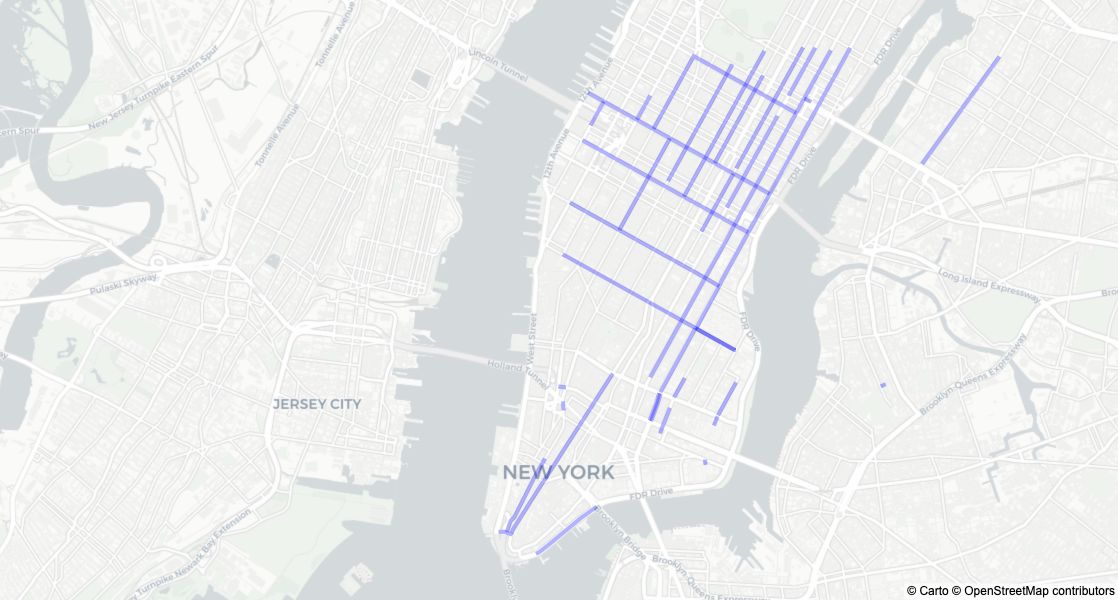

In [216]:
import plotly.graph_objects as go

fig = go.Figure()

lons, lats = [], []
for line in merged.geoms:  # Each piece is a LineString
    x, y = line.xy
    lons.extend(x)
    lats.extend(y)
    # Add None to separate segments in a single trace
    lons.append(None)
    lats.append(None)

fig.add_trace(go.Scattermapbox(
    mode='lines',
    lon=lons,
    lat=lats,
    name='Combined Bus Lanes',
    line=dict(width=4, color='blue'),
    opacity = 0.3
))


fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=12,
    mapbox_center={"lat": 40.735, "lon": -74.0060},
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    height=600,
    width=800,
)

fig.show()


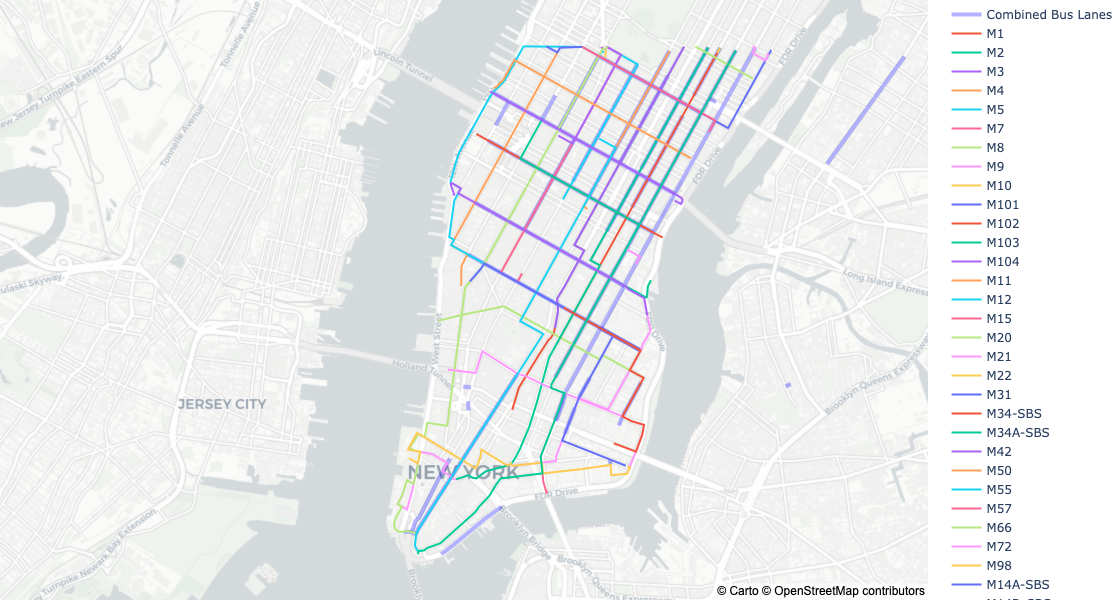

In [218]:
for idx, row in dedupe.iterrows():
    # Check if the geometry is a MultiLineString or a LineString
    if row['geometry'].geom_type == 'MultiLineString':
        for line in row['geometry']:
            x, y = line.xy
            fig.add_trace(go.Scattermapbox(
                mode="lines",
                lon=list(x),
                lat=list(y),
                name=str(row['route_short_name']),
                line=dict(width=2)
            ))
    else:  # LineString
        x, y = row['geometry'].xy
        fig.add_trace(go.Scattermapbox(
            mode="lines",
            lon=list(x),
            lat=list(y),
            name=str(row['route_short_name']),
            line=dict(width=2)
        ))

fig.show()

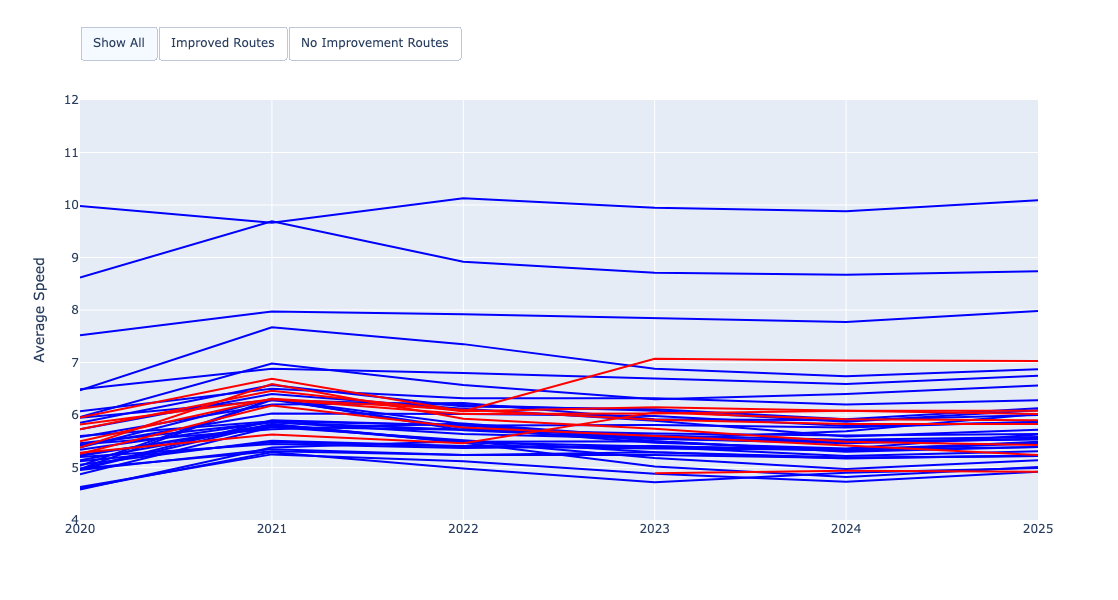

In [268]:
import plotly.graph_objects as go
import pandas as pd

fig = go.Figure()

# Add traces for Group A
improved = plot[plot['performance'] == 'Improved']
for route_id in improved['route_id'].unique():
    subset = improved[improved['route_id'] == route_id]
    fig.add_trace(go.Scatter(
        x=subset['month'], 
        y=subset['average_speed'],
        mode='lines',
        name=f"{route_id}",
        line=dict(color='blue'),
        visible=True  # We'll set the default to visible
    ))

# Add traces for Group B
not_improved = plot[plot['performance'] == 'No Improvement']
for route_id in not_improved['route_id'].unique():
    subset = not_improved[not_improved['route_id'] == route_id]
    fig.add_trace(go.Scatter(
        x=subset['month'], 
        y=subset['average_speed'],
        mode='lines',
        name=f"{route_id}",
        line=dict(color='red'),
        visible=True  # We'll set the default to visible
    ))

# Number of traces in each group
count_a = len(improved['route_id'].unique())
count_b = len(not_improved['route_id'].unique())

# Update menus for filtering
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            direction='left',
            buttons=[
                dict(
                    label='Show All',
                    method='update',
                    args=[
                        {'visible': [True]*(count_a+count_b)}
                    ]
                ),
                dict(
                    label='Improved Routes',
                    method='update',
                    args=[
                        {'visible': [True]*count_a + [False]*count_b}
                    ]
                ),
                dict(
                    label='No Improvement Routes',
                    method='update',
                    args=[
                        {'visible': [False]*count_a + [True]*count_b}
                    ]
                ),
            ],
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.0,
            xanchor="left",
            y=1.2,
            yanchor="top"
        )
    ],

    yaxis_title="Average Speed",
    showlegend=False,
    height = 600, width = 800,
    yaxis_range = [4, 12]
)

fig.show()


In [276]:
dedupe = dedupe.rename(columns = {'route_short_name': 'route_id'})
plot = plot.merge(dedupe, on = 'route_id')
plot.head()

month    borough  day_type trip_type route_id period  total_mileage  \
0 2020-01-01  Manhattan         1   LCL/LTD       M1   Peak     32086461.6   
1 2020-01-01  Manhattan         1   LCL/LTD      M10   Peak     16009628.4   
2 2020-01-01  Manhattan         1   LCL/LTD     M101   Peak     39757881.6   
3 2020-01-01  Manhattan         1   LCL/LTD     M102   Peak     22343940.0   
4 2020-01-01  Manhattan         1   LCL/LTD     M103   Peak     18679046.4   

   total_operating_time  average_speed  year  month_code performance  \
0               5396283           5.95  2020           1    Improved   
1               2929943           5.46  2020           1    Improved   
2               7105686           5.60  2020           1    Improved   
3               4485961           4.98  2020           1    Improved   
4               3775917           4.95  2020           1    Improved   

                                            geometry  
0  LINESTRING (-73.99773 40.7207, -73.99766 40.72...  
1  LINESTRING (-73.98243 40.76793, -73.9824 40.76...  
2  LINESTRING (-73.96408 40.76785, -73.96411 40.7...  
3  LINESTRING (-73.99003 40.7296, -73.98991 40.72...  
4  LINESTRING (-73.96408 40.76785, -73.96411 40.7...

In [382]:
map_plot = plot[['route_id', 'performance', 'geometry']].drop_duplicates()

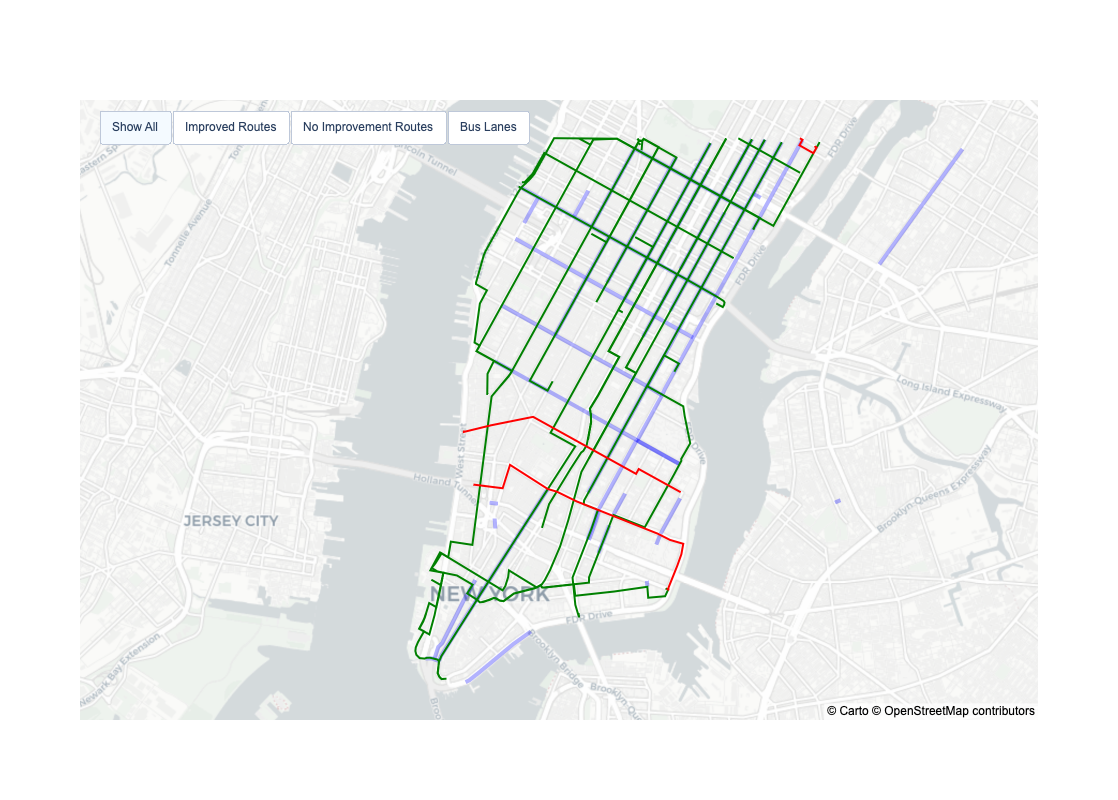

In [404]:
fig = go.Figure()

lons, lats = [], []
for line in merged.geoms:  # Each piece is a LineString
    x, y = line.xy
    lons.extend(x)
    lats.extend(y)
    # Add None to separate segments in a single trace
    lons.append(None)
    lats.append(None)

fig.add_trace(go.Scattermapbox(
    mode='lines',
    lon=lons,
    lat=lats,
    name='Bus Lanes',
    line=dict(width=4, color='blue'),
    opacity = 0.3
))

improved = map_plot[map_plot['performance'] == 'Improved']
for idx, row in improved.iterrows():
    x, y = row['geometry'].xy
    fig.add_trace(go.Scattermapbox(
        mode="lines",
        lon=list(x),
        lat=list(y),
        name=str(row['route_id']),
        line=dict(width=2, color = 'green')
    ))

no_improvement = map_plot[map_plot['performance'] == 'No Improvement']
for idx, row in no_improvement.iterrows():
    x, y = row['geometry'].xy
    fig.add_trace(go.Scattermapbox(
        mode="lines",
        lon=list(x),
        lat=list(y),
        name=str(row['route_id']),
        line=dict(width=2, color = 'red')
    ))

# Number of traces in each group
improved_count = len(improved)
not_improved_count = len(no_improvement)

# Update menus for filtering
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            direction='left',
            buttons=[
                dict(
                    label='Show All',
                    method='update',
                    args=[
                        {'visible': [True] * len(fig.data)}
                    ]
                ),
                dict(
                    label='Improved Routes',
                    method='update',
                    args=[
                        {'visible': [True] + [True]*improved_count + [False] * not_improved_count}
                    ]
                ),
                dict(
                    label='No Improvement Routes',
                    method='update',
                    args=[
                        {'visible': [True] + [False]*improved_count + [True] * not_improved}
                    ]
                ),
                dict(
                    label='Bus Lanes',
                    method='update',
                    args=[
                        {'visible': [True] + [False]*(improved_count + not_improved)}
                    ]
                )
            ],
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.02,
            xanchor="left",
            y=1,
            yanchor="top"
        )
    ],
    mapbox_style="carto-positron",
    mapbox_zoom=12.1,
    mapbox_center={"lat": 40.735, "lon": -73.995},
    showlegend=False,
    height = 800, width = 800,
    yaxis_range = [4, 12],
    font_family = 'Arial'
)

fig.show()